In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyfaidx import Fasta
import logomaker

# plotting modules
from matplotlib.ticker import MultipleLocator
import matplotlib.colors as colors
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 7, 'axes.linewidth': 1, 'xtick.major.width': 1, 'xtick.major.size': 2.5, 'ytick.major.width': 1, 'ytick.major.size': 2.5})
from matplotlib.backends.backend_pdf import PdfPages

genome_fasta = "/data5/deepro/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta"
genome = Fasta(genome_fasta, as_raw=True)

In [2]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight', dpi=300)
    pdf.close()
    return

In [3]:
def create_seq_attr_df(seq, seq_attr):
    data_arr = np.zeros((len(seq), 4))
    nts = ["A", "T", "G", "C"]
    seq_idx = dict(zip(nts, range(len(nts))))
    for i, (s, sq) in enumerate(zip(seq, seq_attr)):
        data_arr[i, seq_idx[s]] = sq
    data_df = pd.DataFrame(data_arr, columns=nts)
    return data_df

def get_complement(seq):
    complement_dict = {
        "A": "T",
        "G": "C",
        "T": "A",
        "C": "G"
        }    
    rev_comp_seq = "".join([complement_dict[s] for s in seq])
    return rev_comp_seq

def get_seq_info(df, idx, genome, seq_attr_arr, reverse=False):
    chrm, start, end = df.iloc[idx].loc[[2, 3, 4]].values
    seq = list(genome.get_seq(chrm, start, end))
    if reverse:
        seq = get_complement(seq)
    seq_attr = np.sum(seq_attr_arr[idx], axis=0)
    return seq, seq_attr, (chrm, start, end)

def create_seqattr_figure_helper(seq, seq_attr, chrm, genome_start, window_coords, title="", figsize=(12, 1)):
    n_windows = len(window_coords)
    total_width = sum(end - start for start, end in window_coords) + (n_windows - 1) * 10  # add space for '...'
    
    full_df = pd.DataFrame(columns=["A", "T", "G", "C"])
    x_ticks = []
    x_tick_labels = []
    current_pos = 0

    for i, (start, end) in enumerate(window_coords):
        subseq = seq[start:end]
        subattr = seq_attr[start:end]
        offset = genome_start + start

        seq_df = create_seq_attr_df(subseq, subattr)

        # Add filler if not first block
        if i > 0:
            ellipsis = pd.DataFrame(np.zeros((10, 4)), columns=["A", "T", "G", "C"])
            full_df = pd.concat([full_df, ellipsis], ignore_index=True)
            current_pos += 10

        full_df = pd.concat([full_df, seq_df], ignore_index=True)

        # Add tick labels
        # Add tick labels: only start and end per block
        x_ticks.extend([current_pos, current_pos + (end - start) - 1])
        x_tick_labels.extend([f"{chrm}:{genome_start + start}", f"{chrm}:{genome_start + end - 1}"])

        current_pos += (end - start)
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    logo = logomaker.Logo(full_df, ax=ax)
    # Add vertical dotted lines at breakpoints
    current_pos = 0
    for i in range(len(window_coords) - 1):
        start, end = window_coords[i]
        window_len = end - start
        current_pos += window_len

        # Draw vertical lines at the END of current window and START of next (offset by gap)
        ax.axvline(current_pos - 0.5, color="black", linestyle="dotted", linewidth=1)           # end of current
        ax.axvline(current_pos + 10 - 0.5, color="black", linestyle="dotted", linewidth=1)      # start of next (after gap)

        # Add axis break in the middle of the gap

        current_pos += 10  # account for gap

    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels, rotation=0, fontsize=7)
    # Align start ticks to left and end ticks to right
    tick_labels = ax.get_xticklabels()
    for i, label in enumerate(tick_labels):
        if i % 2 == 0:  # start of block
            label.set_ha('left')
        else:  # end of block
            label.set_ha('right')

    ax.spines[['right', 'top']].set_visible(False)
    ax.set_ylim(seq_attr.min(), seq_attr.max())
    if title:
        ax.set_title(title)
    plt.close("all")
    return fig, ax


def create_seqattr_figure(lib, chrm, start, end, window_coords, reverse=False, figsize=(12, 2)):
    nlinear_pred_file = f"/data7/deepro/starrseq/4_ml_classification_fragment_category/data/{lib}/resnet_mlp.csv.gz"
    pred_df = pd.read_csv(nlinear_pred_file, header=None)
    selected_df = pred_df.loc[
        (pred_df[2]==chrm)&
        (pred_df[3]==start)&
        (pred_df[4]==end)
        ]
    assert len(selected_df) == 1
    idx = selected_df.index[0]
    seq_arr_file = f"/data7/deepro/starrseq/4_ml_classification_fragment_category/data/{lib}/seq_attr.npy"
    seq_attr_arr = np.load(seq_arr_file)
    seq, seq_attr, (chrm, start, end) = get_seq_info(pred_df, idx, genome, seq_attr_arr, reverse=reverse)
    fig, ax = create_seqattr_figure_helper(seq, seq_attr, chrm, start, window_coords, figsize=figsize)
    return fig, ax, f"{chrm}:{start}-{end}"


In [4]:
plot_dict = {
    "FOXA1": [
        ("chr1", 229231267, 229232267, [(100, 300)], "CREB1_EPAS1"),
        ("chr12", 121765503, 121766503, [(200, 400)], "JUN_FOSL1"),
        ("chr6", 3338553, 3339553, [(225, 325), (500, 600)], "ATF2_CEBPG"),
        ],
    "CC": [
        ("chr2", 45953616, 45954616, [(700, 900)], "ATF2_ATF4"),
        ("chr5", 136042862, 136043862, [(75, 175),  (700, 800)], "ATF2_ATF4"),
    ]
}

In [8]:
for lib, regions in plot_dict.items():
    for chrm, start, end, windows, motif in regions:
        width = 7/200*(sum(end - start for start, end in windows))
        height = 0.375
        fig, ax, region = create_seqattr_figure(
            lib, chrm, start, end, windows, figsize=(width, height)
            )    
        save_file = f"/data7/deepro/starrseq/4_ml_classification_fragment_category/data/figures/{lib}_{motif}_{region.replace(':', '_').replace('-', '_')}.pdf"
        save_pdf(save_file, fig)
        print(f"Saved figure to {save_file}")


Saved figure to /data7/deepro/starrseq/4_ml_classification_fragment_category/data/figures/FOXA1_CREB1_EPAS1_chr1_229231267_229232267.pdf
Saved figure to /data7/deepro/starrseq/4_ml_classification_fragment_category/data/figures/FOXA1_JUN_FOSL1_chr12_121765503_121766503.pdf
Saved figure to /data7/deepro/starrseq/4_ml_classification_fragment_category/data/figures/FOXA1_ATF2_CEBPG_chr6_3338553_3339553.pdf
Saved figure to /data7/deepro/starrseq/4_ml_classification_fragment_category/data/figures/CC_ATF2_ATF4_chr2_45953616_45954616.pdf
Saved figure to /data7/deepro/starrseq/4_ml_classification_fragment_category/data/figures/CC_ATF2_ATF4_chr5_136042862_136043862.pdf


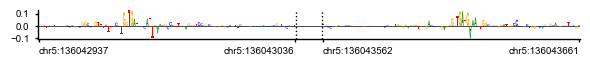

In [6]:
fig

# TODO
1. Only keep atmost 200 bp covering the two motifs, 100, 100 goal: If required, add dots in between
2. Mark the correct coordinates in the plot - if there are dots, those coordinates should be marked
3. 

In [53]:
homer_df = pd.read_csv(
    "/data7/deepro/starrseq/4_ml_classification_fragment_category/data/FOXA1/linear/homer/motif_odds.tsv", 
    sep="\t"
)

In [57]:
homer_df.loc[homer_df.PositionID=="chr1_229231267_229232267"].sort_values("MotifScore", ascending=False).head(50)

,PositionID,Offset,Sequence,Motif Name,Strand,MotifScore
46090443,chr1_229231267_229232267,500,TTCTATTTCTACTTGGGAAA,ZFP28_HUMAN.H11MO.0.C,+,13.113749
46818490,chr1_229231267_229232267,359,GCACAGCGGGGAGCC,ZIC3_HUMAN.H11MO.0.B,-,11.563162
29082248,chr1_229231267_229232267,247,GGACGTGCCCTAACTTGCT,P73_HUMAN.H11MO.0.A,+,10.812296
3906916,chr1_229231267_229232267,893,GGCTCTCCAGGGACC,COE1_HUMAN.H11MO.0.A,+,10.768831
28990517,chr1_229231267_229232267,248,GACGTGCCCTAACTTGCTT,P63_HUMAN.H11MO.0.A,+,10.732469
28889618,chr1_229231267_229232267,247,GGACGTGCCCTAACTTGCTT,P53_HUMAN.H11MO.0.A,+,10.611951
7161368,chr1_229231267_229232267,692,GGGGCGGGGTGGGTGGTG,EGR2_HUMAN.H11MO.0.A,+,10.200962
2678599,chr1_229231267_229232267,376,TGCCTGGAAAGCA,BCL6_HUMAN.H11MO.0.A,-,10.008901
41370942,chr1_229231267_229232267,616,CCAGCTGTGG,TFAP4_HUMAN.H11MO.0.A,+,9.650590
15226264,chr1_229231267_229232267,615,ACCAGCTGTG,HTF4_HUMAN.H11MO.0.A,+,9.522143


In [ ]:
pred_df.loc[pred_df.unique_id == "chr1_229231267_229232267"]

Int64Index([56], dtype='int64')